# Les projets Open Source de Machine Learning sont-ils menés par des chercheurs ?

## Préambule

Nous observons l'apparition fréquente de nouveaux algorithmes de Machine Learning et leur intégration à des bibliothèques Open Source.

Nous pensons que de nombreux contributeurs hétéroclites participent à ces projets notamment une minorité de chercheurs qui effectuent des travaux dans le domaine de l'apprentissage automatique, mais que ce sont ces chercheurs qui contribuent majoritairement à l'avancée de ces projets.

Nous souhaitons évaluer les hypothèses suivantes :
* Les contributeurs ne sont pas majoritairement des chercheurs.
* Les contributions viennent majoritairement de chercheurs.
* Les chercheurs sont les contributeurs qui contribuent le plus individuellement.

Nos hypothèses de travail définissent certaines notions et concernent la bonne foi des contributeurs dans les informations de *commit* :
* Un chercheur possède une adresse mail d'une académie *ou* possède un profil d'auteur de publications sur Google Scholar.
* Le nom/prénom spécifié dans chaque *commit* est celui de l'auteur.
* L'adresse mail spécifiée dans chaque *commit* est celui de l'auteur.

Pour avoir un horizon le plus large possible, nous allons mener l'étude sur quatorze projet open source de Machine Learning (voir la liste à la racine de notre [dépôt Git](https://github.com/AntoineAube/reace-study)).

Les données que nous exploitons dans ce document sont issues de l'exécution de plusieurs scripts :
* Extraction d'informations depuis le dépôt Git des projets avec Repodriller.
* Classification des critères pour déterminer quels utilisateurs sont des chercheurs.
Le nécessaire pour reproduire l'étude est disponible sur notre dépôt Git.

In [1]:
# Let us import some awesome libraries!
import pandas as pd
import numpy as np
import math
import os

import pygal

# Definition of some constants.
DATASETS_LOCATION = 'drilled-informations/commits-information'

In [2]:
# Let us load the commits datasets.

projects_commits = {}

for filename in map(lambda filename: filename.split('.csv')[0], os.listdir(DATASETS_LOCATION)):
    commits = pd.read_csv(DATASETS_LOCATION + '/' + filename + '.csv')
    
    # Add a PROJECT column because they are going to be merged.
    commits['PROJECT'] = filename
    
    # The generated timestamps are 1000 times to big for unknown reason.
    commits['TIMESTAMP'] /= 1000
    
    projects_commits[filename] = commits
    
projects_commits['scikit-learn'].sample(3)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES,PROJECT
13346,558cf06a96b83eb43d74df53dce490525b32d120,Lars Buitinck,larsmans@gmail.com,2,1.371894e+09,9,3,0,scikit-learn
12808,fcad90d91c8cbf29e0476f4f385bcf45759eaf8e,Andreas Mueller,amueller@ais.uni-bonn.de,1,1.362506e+09,20,20,0,scikit-learn
9575,48a08d76c7e3d024d535a1ebe1661cdc2149b080,Peter Prettenhofer,peter.prettenhofer@gmail.com,1,1.338650e+09,1,1,0,scikit-learn


## Quels sont les contributeurs chercheurs ?

Conformément à notre hypothèse de travail, nous avons retenu deux critères pour déterminer quel contributeur est un chercheur.

Un script ultérieurement exécuté a constitué un set de données de la manière suivante :
* À partir de la liste des *commits* de chaque projet, lister les contributeurs par leur nom ; pour chaque contributeur, lister ses adresses mail.
* À partir d'une liste blanche de domaines d'adresses mail académiques, déterminer pour chaque contributeur s'il a au moins une adresse académique.
* À partir du nom de chaque contributeur, faire une recherche d'auteur de publications sur Google Scholar pour déterminer s'il en est connu ou non.

In [3]:
contributors_status = pd.read_csv('known-contributors.csv')

contributors_status.sample(3)

,NAME,HAS_RESEARCHER_EMAIL,HAS_PUBLICATION
3961,Igor Andriushchenko,False,False
1698,Ming Li,False,NaN
2286,Nick Babcock,False,False


En conservant l'union des deux colonnes calculées, nous pouvons déterminer quels contributeurs nous considérons être des chercheurs.

In [4]:
def decide_if_researcher(row):
    if math.isnan(row['HAS_RESEARCHER_EMAIL']):
        row['IS_RESEARCHER'] = row['HAS_PUBLICATION']
    elif math.isnan(row['HAS_PUBLICATION']):
        row['IS_RESEARCHER'] = row['HAS_RESEARCHER_EMAIL']
    else:
        row['IS_RESEARCHER'] = row['HAS_PUBLICATION'] or row['HAS_RESEARCHER_EMAIL']
        
    return row

contributors_status = contributors_status.apply(decide_if_researcher, axis = 1)

contributors_status.set_index('NAME', inplace = True)

contributors_status.sample(3)

,HAS_RESEARCHER_EMAIL,HAS_PUBLICATION,IS_RESEARCHER
NAME,,,
Erwin Marsi,True,True,True
ngoix,False,False,False
Alvaro Ulloa,False,True,True


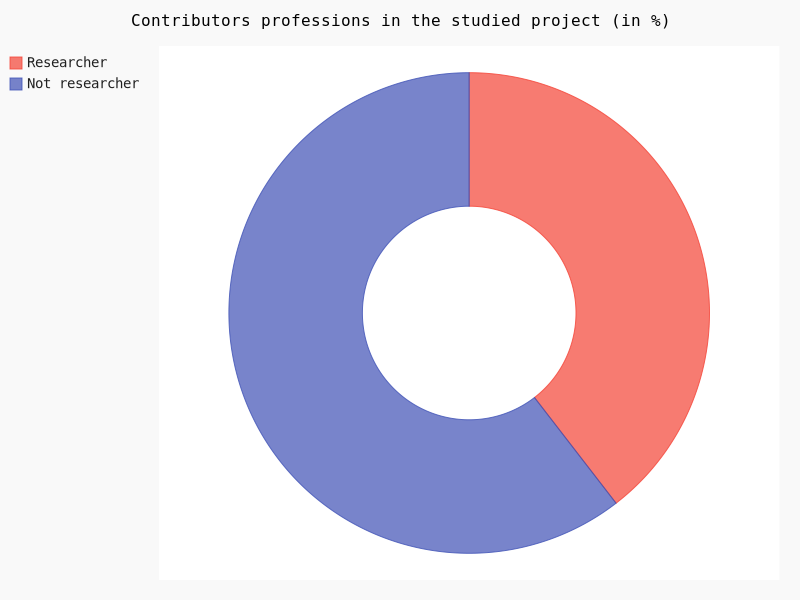

In [5]:
researchers_distribution = contributors_status['IS_RESEARCHER'].value_counts() / len(contributors_status)

pie = pygal.Pie(inner_radius = .4)
pie.title = 'Contributors professions in the studied project (in %)'
pie.add('Researcher', researchers_distribution[True])
pie.add('Not researcher', researchers_distribution[False])

In [6]:
# Let us annotate the commits for future uses.
def commit_has_been_made_by_researcher(row):
    global contributors_status
    
    row['IS_RESEARCHER'] = contributors_status['IS_RESEARCHER'][row['AUTHOR_NAME']]
    
    return row

for project_name in projects_commits.keys():
    commits = projects_commits[project_name]
    
    projects_commits[project_name] = commits.apply(commit_has_been_made_by_researcher, axis = 1)

## Questions de l'étude

Les hypothèses de l'étude infèrent les sous-questions suivantes :
* Les contributeurs sont-ils majoritairement des chercheurs ?
* Les contributions sont-elles majoritairement produites par des chercheurs ?
* Les chercheurs sont-ils les contributeurs qui contribuent le plus individuellement ?

Les données que nous avons préparées vont nous permettre de répondre à ces questions. Quand il s'agit de comparer la quantité de contributions, nous prenons soin d'effectuer le comparatif sur le nombre de *commits* ainsi que sur le nombre de lignes ajoutées/retirées.

In [7]:
commits = pd.concat(projects_commits.values())
commits.reset_index(drop = True, inplace = True)

commits.sample(3)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES,PROJECT,IS_RESEARCHER
118820,4d821f673babc6d009ebfd3e671514182df9d726,Vijay Mahantesh SM,vijay@vijay.(none),1,1.340138e+09,17,70,0,simplecv,False
67114,0c6696f88b44b01b9b48b76ceb02fa9794f267e0,Pascal Lamblin,lamblinp@iro.umontreal.ca,3,1.238531e+09,40,35,0,pylearn,True
98265,6f215871f109ac06cc065767f722564078b74c3d,Alexandre Abraham,abraham.alexandre@gmail.com,1,1.474210e+09,2,1,0,nilearn,True


### Les contributeurs sont-ils majoritairement des chercheurs ?

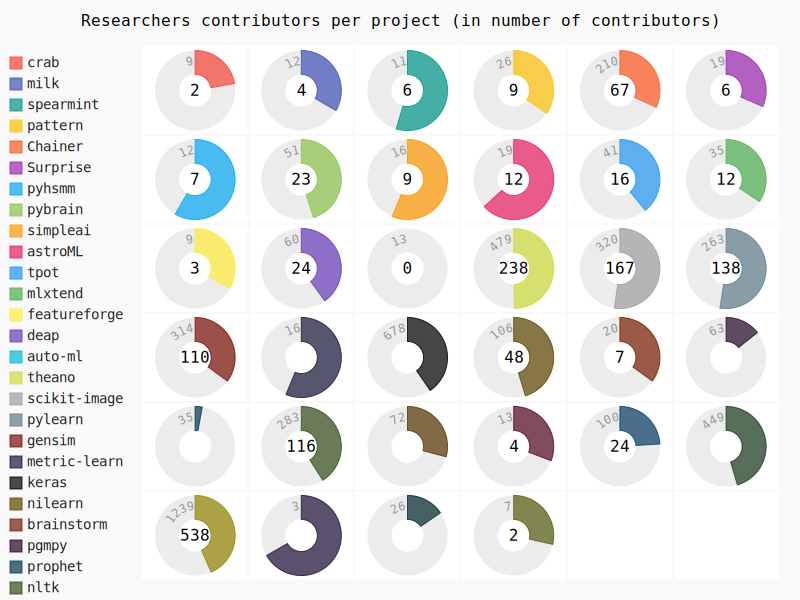

In [8]:
gauge = pygal.SolidGauge(inner_radius = .4)

gauge.title = 'Researchers contributors per project (in number of contributors)'

for project_name in projects_commits.keys():
    project_commits = projects_commits[project_name]
    
    unique_contributors = project_commits.drop_duplicates(['PROJECT', 'AUTHOR_NAME'])['IS_RESEARCHER']
    
    statuses_count = unique_contributors.value_counts()
    
    gauge.add(project_name, [{'value': (statuses_count[True] if True in statuses_count.index else 0), 'max_value': len(unique_contributors)}])
    
display({'image/svg+xml': gauge.render()}, raw=True)

##### Observations

Sur les quatorze projets étudiés, nous avons :
* Un projet qui ne compte aucun chercheur (*auto-ml*).
* Deux projets dont les contributeurs sont majoritairement des chercheurs (*scikit-image*, *cogitare*).
* Onze projets dont les contributeurs ne sont pas majoritairement des chercheurs.


Nous pouvons conclure, pour cet échantillon de projet, que les chercheurs ne sont pas en majorité dans les projets open source de Machine Learning.

##### Ouverture

Nous observons que dans la plupart des projets, un quart des contributeurs au moins est composé de chercheurs (vrai pour douze projets, sur quatorze). Nous nous posons la question : cette observation pourrait-elle être faite pour n'importe quel type de projet open source ?

### Les contributions sont-elles majoritairement produites par des chercheurs ?

#### En nombre de *commits*

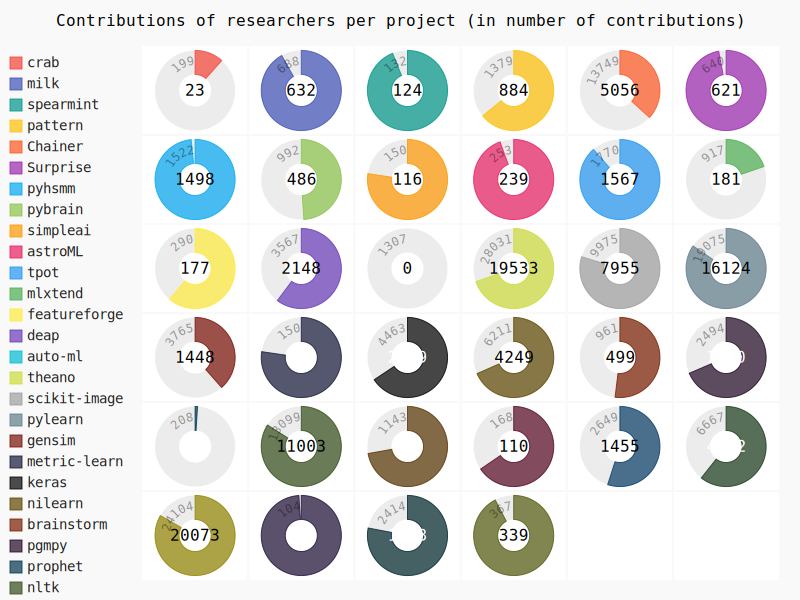

In [9]:
gauge = pygal.SolidGauge(inner_radius = .4)

gauge.title = 'Contributions of researchers per project (in number of contributions)'

for project_name in projects_commits.keys():
    project_commits = projects_commits[project_name]
    
    statuses_count = project_commits['IS_RESEARCHER'].value_counts()
    
    gauge.add(project_name, [{'value': (statuses_count[True] if True in statuses_count.index else 0), 'max_value': len(project_commits)}])
    
display({'image/svg+xml': gauge.render()}, raw=True)

#### En nombre de lignes ajoutées/retirées

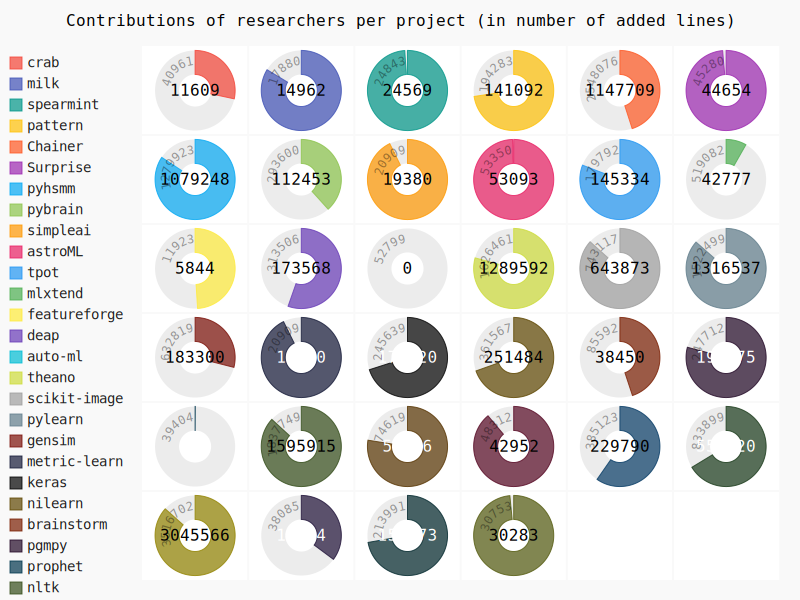

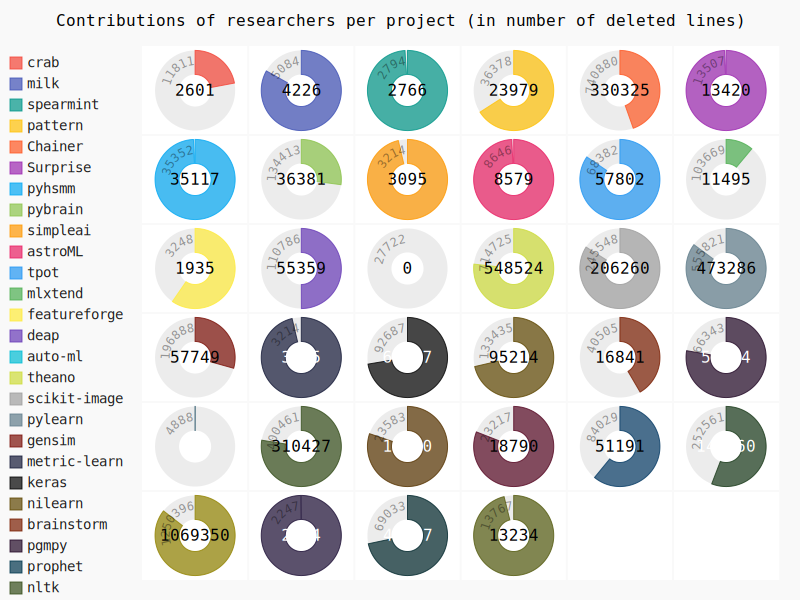

In [10]:
added_lines_gauge = pygal.SolidGauge(inner_radius = .4)
added_lines_gauge.title = 'Contributions of researchers per project (in number of added lines)'

deleted_lines_gauge = pygal.SolidGauge(inner_radius = .4)
deleted_lines_gauge.title = 'Contributions of researchers per project (in number of deleted lines)'

for project_name in projects_commits.keys():
    project_commits = projects_commits[project_name]
    
    added_lines_gauge.add(project_name, 
                          [{'value': project_commits['ADDED_LINES'][project_commits['IS_RESEARCHER'] == True].sum(),
                            'max_value': project_commits['ADDED_LINES'].sum()}])
    
    deleted_lines_gauge.add(project_name, 
                          [{'value': project_commits['DELETED_LINES'][project_commits['IS_RESEARCHER'] == True].sum(),
                            'max_value': project_commits['DELETED_LINES'].sum()}])
    
display({'image/svg+xml': added_lines_gauge.render()}, raw=True)
display({'image/svg+xml': deleted_lines_gauge.render()}, raw=True)

##### Observations

Bien que les observations diffèrent en fonction de la notion de contribution (nombre de *commits* ou nombre de *lignes ajoutées/retirées*), nous observons que la tendance est à une grande participation des chercheurs à la progression des projets :
* Les *commits* sont majoritairement faits par des chercheurs dans douze projets sur quatorze.
* Les lignes sont majoritairement écrites par des chercheurs dans dix projets sur quatorze.
* Les lignes sont majoritairement supprimées par des chercheurs dans onze projets sur quatorze.

Nous observons également des *anomalies* :
* Dans *cogitare*, toutes les contributions sauf une proviennent de chercheurs, mais moins de la moitié des lignes de code a été écrit par eux. Ce *commit* a été produit par "Travis CI User" (outil d'intégration continue), c'est donc une erreur de l'avoir conservé.
* Le projet *auto-ml* parasite les résultats car nous avons déterminé au point précédent qu'aucun chercheur n'a contribué à ce projet.

### Les chercheurs sont-ils les contributeurs qui contribuent le plus individuellement ?

In [11]:
def decide_if_commit_made_by_researcher(row):
    global contributors_status
    
    row['IS_RESEARCHER'] = contributors_status['IS_RESEARCHER'][row['NAME']]
    
    return row

def compute_contributors_statistics(commits):
    statistics = pd.DataFrame(index = commits['AUTHOR_NAME'].unique())
    
    statistics['NUMBER_OF_COMMITS'] = 0
    statistics['ADDED_LINES'] = 0
    statistics['DELETED_LINES'] = 0
    statistics['MODIFIED_LINES'] = 0
    
    for index, row in commits.iterrows():
        name = row['AUTHOR_NAME']
        
        statistics['NUMBER_OF_COMMITS'][name] += 1
        statistics['ADDED_LINES'][name] += row['ADDED_LINES']
        statistics['DELETED_LINES'][name] += row['DELETED_LINES']
        statistics['MODIFIED_LINES'][name] += row['ADDED_LINES'] + row['DELETED_LINES']
        
    statistics['NAME'] = statistics.index
    
    statistics = statistics.apply(decide_if_commit_made_by_researcher, axis = 1)
    
    statistics.reset_index(drop = True, inplace = True)
        
    return statistics

projects_contributors = {}

for project_name in projects_commits.keys():
    contributors = compute_contributors_statistics(projects_commits[project_name])
    contributors['PROJECT'] = project_name
    
    projects_contributors[project_name] = contributors
    
contributors = pd.concat(projects_contributors.values())
contributors.reset_index(drop = True, inplace = True)

contributors.sample(3)

,NUMBER_OF_COMMITS,ADDED_LINES,DELETED_LINES,MODIFIED_LINES,NAME,IS_RESEARCHER,PROJECT
231,2,8,8,16,中西 健,True,Chainer
4723,1,1,1,2,Paul Ganssle,True,scikit-learn
781,55,759,388,1147,Ziye Fan,False,theano


#### En nombre de *commits*

In [12]:
for project_name in contributors['PROJECT'].unique():
    project_contributors = contributors[contributors['PROJECT'] == project_name]
    
    print('For project', project_name + ':')
    print()
    print('Researchers:')
    print(project_contributors[project_contributors['IS_RESEARCHER'] == True]['NUMBER_OF_COMMITS'].describe())
    print()
    print('Non researchers:')
    print(project_contributors[project_contributors['IS_RESEARCHER'] == False]['NUMBER_OF_COMMITS'].describe())
    print()
    print()
    print()

For project crab:

Researchers:
count     2.000000
mean     11.500000
std      13.435029
min       2.000000
25%       6.750000
50%      11.500000
75%      16.250000
max      21.000000
Name: NUMBER_OF_COMMITS, dtype: float64

Non researchers:
count      7.000000
mean      25.142857
std       50.916365
min        1.000000
25%        1.000000
50%        9.000000
75%       12.000000
max      140.000000
Name: NUMBER_OF_COMMITS, dtype: float64



For project milk:

Researchers:
count      4.000000
mean     158.000000
std      244.386306
min        1.000000
25%        1.750000
50%       57.500000
75%      213.750000
max      516.000000
Name: NUMBER_OF_COMMITS, dtype: float64

Non researchers:
count     8.000000
mean      7.000000
std      13.804761
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      41.000000
Name: NUMBER_OF_COMMITS, dtype: float64



For project spearmint:

Researchers:
count      6.000000
mean      20.666667
std       39.843025
min        1.

count     2.000000
mean     51.500000
std      33.234019
min      28.000000
25%      39.750000
50%      51.500000
75%      63.250000
max      75.000000
Name: NUMBER_OF_COMMITS, dtype: float64

Non researchers:
count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: NUMBER_OF_COMMITS, dtype: float64



For project skll:

Researchers:
count       4.00000
mean      470.75000
std       507.66549
min         9.00000
25%        91.50000
50%       383.50000
75%       762.75000
max      1107.00000
Name: NUMBER_OF_COMMITS, dtype: float64

Non researchers:
count     22.000000
mean      24.136364
std       45.413754
min        1.000000
25%        3.250000
50%        9.000000
75%       27.750000
max      211.000000
Name: NUMBER_OF_COMMITS, dtype: float64



For project hebel:

Researchers:
count      2.000000
mean     169.500000
std      235.466558
min        3.000000
25%       86.250000
50%      169.500000
75%      252.750000
max      336.0000

#### En nombre de lignes ajoutées/retirées

In [13]:
for project_name in contributors['PROJECT'].unique():
    project_contributors = contributors[contributors['PROJECT'] == project_name]
    
    print('For project', project_name + ':')
    print()
    print('Researchers:')
    print(project_contributors[project_contributors['IS_RESEARCHER'] == True]['ADDED_LINES'].describe())
    print()
    print('Non researchers:')
    print(project_contributors[project_contributors['IS_RESEARCHER'] == False]['ADDED_LINES'].describe())
    print()
    print()
    print()

For project crab:

Researchers:
count        2.000000
mean      5804.500000
std       8203.145769
min          4.000000
25%       2904.250000
50%       5804.500000
75%       8704.750000
max      11605.000000
Name: ADDED_LINES, dtype: float64

Non researchers:
count        7.000000
mean      4193.142857
std       9843.042135
min          1.000000
25%          4.500000
50%        291.000000
75%       1292.000000
max      26467.000000
Name: ADDED_LINES, dtype: float64



For project milk:

Researchers:
count        4.000000
mean      3740.500000
std       5166.726914
min          1.000000
25%         18.250000
50%       1996.500000
75%       5718.750000
max      10968.000000
Name: ADDED_LINES, dtype: float64

Non researchers:
count       8.00000
mean      364.75000
std       977.83825
min         1.00000
25%         1.75000
50%        15.00000
75%        37.00000
max      2784.00000
Name: ADDED_LINES, dtype: float64



For project spearmint:

Researchers:
count        6.000000
mean      4

For project Lasagne:

Researchers:
count       21.000000
mean      2754.571429
std       7407.260759
min          1.000000
25%          6.000000
50%         63.000000
75%        670.000000
max      26766.000000
Name: ADDED_LINES, dtype: float64

Non researchers:
count      51.000000
mean      328.882353
std       762.649452
min         0.000000
25%         5.500000
50%        77.000000
75%       289.000000
max      4203.000000
Name: ADDED_LINES, dtype: float64



For project pyevolve:

Researchers:
count        4.000000
mean     10738.000000
std      17659.886202
min          1.000000
25%        136.750000
50%       3019.500000
75%      13620.750000
max      36912.000000
Name: ADDED_LINES, dtype: float64

Non researchers:
count       9.000000
mean      595.555556
std      1164.057785
min         2.000000
25%         6.000000
50%        49.000000
75%       807.000000
max      3556.000000
Name: ADDED_LINES, dtype: float64



For project simplecv:

Researchers:
count        24.000000
mean

In [14]:
for project_name in contributors['PROJECT'].unique():
    project_contributors = contributors[contributors['PROJECT'] == project_name]
    
    print('For project', project_name + ':')
    print()
    print('Researchers:')
    print(project_contributors[project_contributors['IS_RESEARCHER'] == True]['DELETED_LINES'].describe())
    print()
    print('Non researchers:')
    print(project_contributors[project_contributors['IS_RESEARCHER'] == False]['DELETED_LINES'].describe())
    print()
    print()
    print()

For project crab:

Researchers:
count       2.000000
mean     1300.500000
std      1833.527884
min         4.000000
25%       652.250000
50%      1300.500000
75%      1948.750000
max      2597.000000
Name: DELETED_LINES, dtype: float64

Non researchers:
count       7.000000
mean     1315.714286
std      2698.478628
min         1.000000
25%         2.000000
50%        72.000000
75%       887.500000
max      7358.000000
Name: DELETED_LINES, dtype: float64



For project milk:

Researchers:
count       4.000000
mean     1056.500000
std      1722.641866
min         0.000000
25%         1.500000
50%       311.500000
75%      1366.500000
max      3603.000000
Name: DELETED_LINES, dtype: float64

Non researchers:
count      8.000000
mean     107.250000
std      293.275955
min        0.000000
25%        0.750000
50%        2.500000
75%        8.250000
max      833.000000
Name: DELETED_LINES, dtype: float64



For project spearmint:

Researchers:
count       6.000000
mean      461.000000
std    

Non researchers:
count     7.000000
mean     17.000000
std      19.680786
min       1.000000
25%       2.500000
50%       3.000000
75%      31.000000
max      48.000000
Name: DELETED_LINES, dtype: float64



For project keras:

Researchers:
count      274.000000
mean       244.770073
std       2738.362813
min          0.000000
25%          1.000000
50%          3.000000
75%         14.750000
max      44768.000000
Name: DELETED_LINES, dtype: float64

Non researchers:
count     404.000000
mean       63.415842
std       533.918187
min         0.000000
25%         1.000000
50%         2.500000
75%        10.000000
max      9775.000000
Name: DELETED_LINES, dtype: float64



For project nilearn:

Researchers:
count       48.000000
mean      1983.625000
std       4651.022069
min          0.000000
25%         11.750000
50%        151.000000
75%        705.750000
max      21390.000000
Name: DELETED_LINES, dtype: float64

Non researchers:
count       58.000000
mean       658.982759
std       200